## Reproducible Example
Our goal: to cluster sires using several different traits.

#### Description of the data
The file "evaluations.csv" has several sire evaluations scraped from the web. Each line of the data is a sire (which is identified by "sire_id_") and an evaluation date ("EvalDate"). As more data becomes available on the sire, the numbers begin to be updated. This is reflected in a number called "reliability," which shows how much variance there is in the number.

We use 5 traits to cluster. Each trait begins with the letters "PTA" because it stands for "Predicted Transmitting Ability." All of them are calculated with respect to a base, which is PTA=0.

Along with the PTA's, there is an index of PTA's called "Net Merit" (variable "NM$") which is a linear combination of PTA's weighted by economic values.

Explanation of traits:
- Milk Yield: the lbs of milk produced by a cow
- Fat: the lbs of fat
- Protein: the lbs of protein
- DPR: daughter pregnancy rate, a measure of reproductive success.
- SCC: somatic cell count, a measure of health and milk bacteria level.

The first three are productive traits while the last two are health traits.

In [1]:
import numpy as np
import pandas as pd
import gcsfs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline
from sklearn.preprocessing import scale, StandardScaler
from multiprocessing import Pool

/home/jhutchins/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Data Reading

In [2]:
linux_street_cred = "/home/jhutchins/.config/gcloud/legacy_credentials/jaredphutchins@gmail.com/adc.json"
mac_street_cred = "/Users/jhutchins/.config/gcloud/legacy_credentials/jaredphutchins@gmail.com/adc.json"
gcloud_street_cred = "/home/jaredphutchins/adc.json"


#datadir='/home/jaredphutchins/datadisk/'

fs = gcsfs.GCSFileSystem(project='dairy-168114',token=linux_street_cred)
#fs = gcsfs.GCSFileSystem(project='dairy-168114')

with fs.open('sire-eval/evaluations.csv') as f:
    data = pd.read_csv(f)

### Data Cleaning

In [4]:
# Only use official evaluations
data = data[data['Official']=='Y']

# NM percentile
data['NMPctl'] = data['NMPctl'].replace('--',0).replace('++',100).astype(float)

# All variables are adjusted by their "reliability" numbers to bias them towards 
# 0 if there is not enough information on them.
data['PTAMilk_adj'] = data['PTAMilk']*(data['MilkREL']/100)
data['PTAFat_adj'] = data['PTAFat']*(data['ProREL']/100)
data['PTAPro_adj'] = data['PTAPro']*(data['ProREL']/100)
data['PTAPL_adj'] = data['PTAPL']*(data['PLREL']/100)
data['PTASCS_adj'] = data['PTASCS']*(data['SCSREL']/100)
data['PTADPR_adj'] = data['PTADPR']*(data['DPRREL']/100)
data['PTACCR_adj'] = data['PTACCR']*(data['CCRREL']/100)
data['NM_adj'] = data['NM$']*(data['NM$REL']/100)

# These are the things we are clustering on
cluster_cols = ['PTAMilk_adj','PTAFat_adj','PTAPro_adj','PTASCS_adj','PTADPR_adj']
cluster_data = data[cluster_cols +['sire_id_','EvalDate','NM_adj','NMPctl']].dropna().reset_index(drop=True)

X = cluster_data[cluster_cols].dropna()
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)
X.columns = cluster_cols

### Cluster selection

Using the "silhouette score" measure.

Skip this section if you already know the number of clusters you want to use.

In [ ]:
# returns the silhouette score of a given K
def kmeans_score(K):
    kmeans = KMeans(n_clusters=K,random_state=0)
    X['cluster'] = kmeans.fit_predict(X)
    return silhouette_score(X,X['cluster'],sample_size=1000)

# parallelized operation.
pool = Pool()
sil_scores = pool.map(kmeans_score,range(2,30))
pool.close()

# A plot of the resulting clusters
scores = pd.Series(sil_scores)
scores.index = list(range(2,30))
scores.plot()

### Cluster estimation

In [18]:
K=10
kmean = KMeans(n_clusters=K,random_state=0)

X['cluster'] = kmean.fit_predict(X.values)
# Clusters are renamed so as to be sorted by milk yield
clusters_by_milk = list(X.groupby('cluster').mean().sort_values('PTAMilk_adj').index)
X['cluster'] = X['cluster'].replace(to_replace=clusters_by_milk,value=list(range(K)))

cluster_data['cluster']= X['cluster']

### Graphs of clusters

/home/jhutchins/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/jhutchins/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/jhutchins/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/jhutchins/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkw

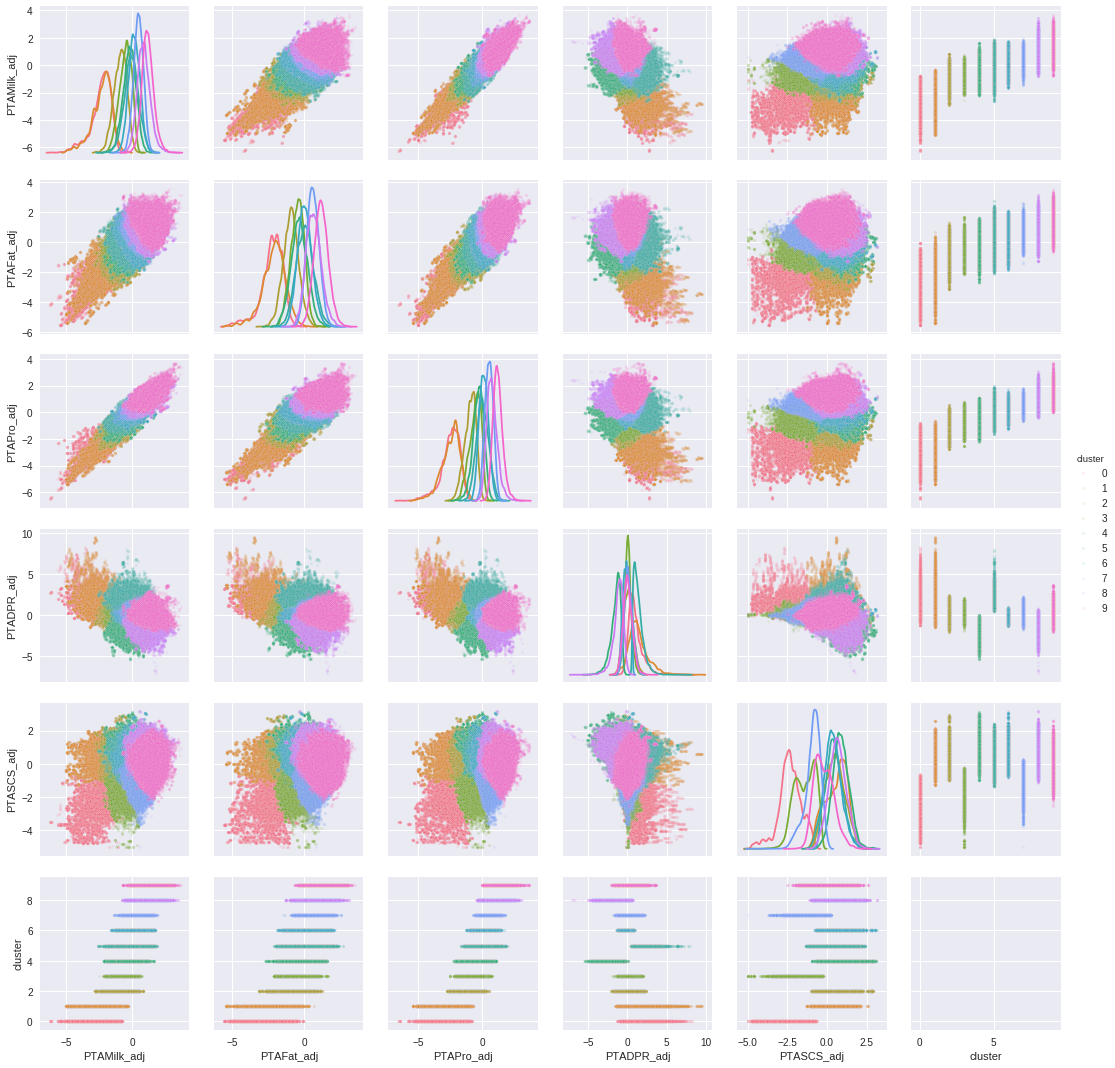

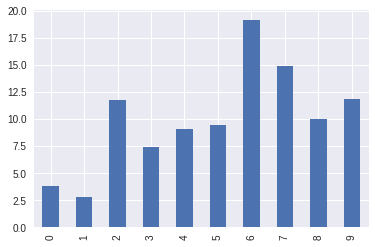

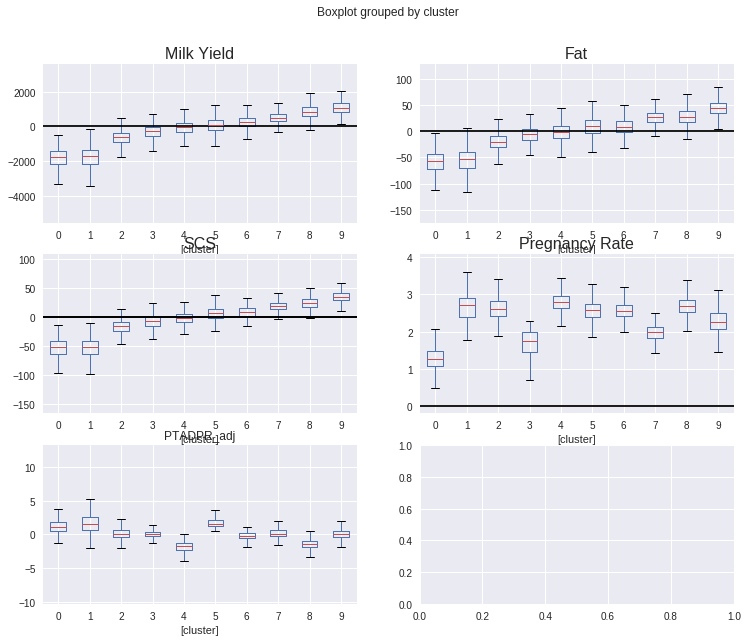

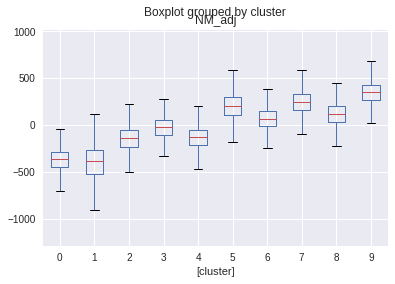

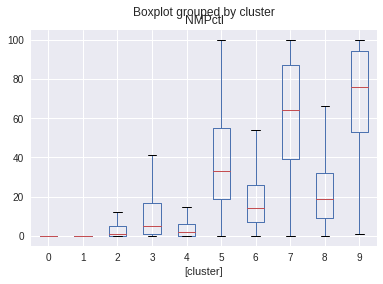

In [36]:
dem_graphs = sns.pairplot(X[['PTAMilk_adj','PTAFat_adj','PTAPro_adj','PTADPR_adj','PTASCS_adj','cluster']],\
                          hue='cluster',diag_kind="kde",\
                          plot_kws=dict(s=10, alpha=.1))

plt.figure()
(X.cluster.value_counts(normalize=True).sort_index()*100).plot(kind='bar')

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,10))
fig.suptitle("Title centered above all subplots", fontsize=14)

cluster_data[['PTAMilk_adj','cluster']].boxplot(by='cluster',ax=axes[0,0])
axes[0,0].set_title('Milk Yield',fontsize=16)
axes[0,0].axhline(0,color='black')

cluster_data[['PTAFat_adj','cluster']].boxplot(by='cluster',ax=axes[0,1])
axes[0,1].set_title('Fat',fontsize=16)
axes[0,1].axhline(0,color='black')

cluster_data[['PTAPro_adj','cluster']].boxplot(by='cluster',ax=axes[1,0])
axes[1,0].set_title('Protein',fontsize=16)
axes[1,0].axhline(0,color='black')

cluster_data[['PTASCS_adj','cluster']].boxplot(by='cluster',ax=axes[1,1])
axes[1,0].set_title('SCS',fontsize=16)
axes[1,0].axhline(0,color='black')


# X[['PTASCS','cluster']].boxplot(by='cluster')
cluster_data[['PTADPR_adj','cluster']].boxplot(by='cluster',ax=axes[2,0])
axes[1,1].set_title('Daughter Pregnancy Rate',fontsize=16)
axes[1,1].axhline(0,color='black')

cluster_data[['NM_adj','cluster']].boxplot(by='cluster')
cluster_data[['NMPctl','cluster']].boxplot(by='cluster')

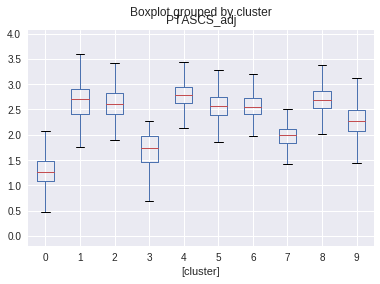

In [27]:
%matplotlib inline

In [30]:
cluster_data.sire_id_.nunique()

32490